In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [49]:
df = pd.read_csv('data/Indicative Wholesale and Agile Import Pricing (30 minute)-data-22-07-2024 19_00_52.csv',
                 parse_dates=[0])

df.fillna(method = 'bfill', inplace=True)
df.reset_index()
df.head()

,Time,Indicative Wholesale Unit Price (p)
0,2019-07-22 18:30:00,4.8
1,2019-07-22 19:00:00,4.8
2,2019-07-22 19:30:00,5.1
3,2019-07-22 20:00:00,4.7
4,2019-07-22 20:30:00,4.6


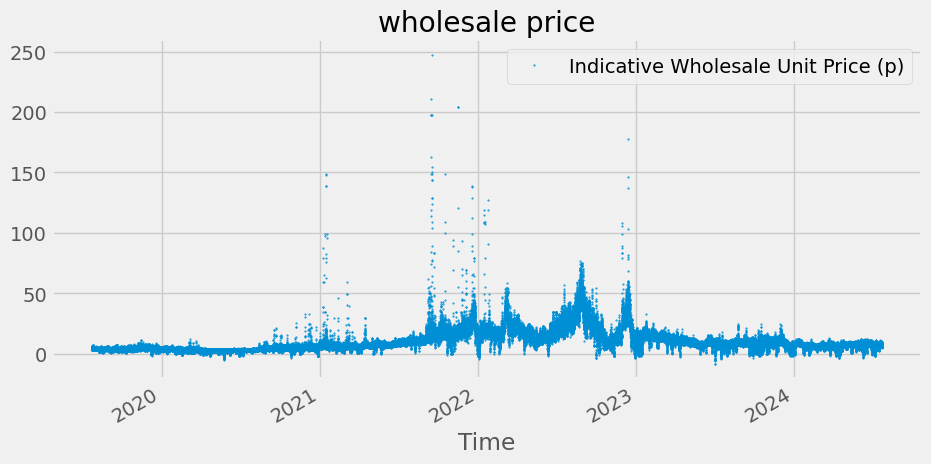

In [52]:
color_pal = sns.color_palette()
df.plot(x = 'Time', y= 'Indicative Wholesale Unit Price (p)', style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='wholesale price')
plt.show()

In [56]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.Time
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Autumn', 'Winter']
                   )
    X = df[['Time', 'hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='Indicative Wholesale Unit Price (p)')
features_and_target = pd.concat([X, y], axis=1)

In [57]:
features_and_target.head()

,Time,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekday,season,Indicative Wholesale Unit Price (p)
0,2019-07-22 18:30:00,18,0,3,7,2019,203,22,Monday,Summer,4.8
1,2019-07-22 19:00:00,19,0,3,7,2019,203,22,Monday,Summer,4.8
2,2019-07-22 19:30:00,19,0,3,7,2019,203,22,Monday,Summer,5.1
3,2019-07-22 20:00:00,20,0,3,7,2019,203,22,Monday,Summer,4.7
4,2019-07-22 20:30:00,20,0,3,7,2019,203,22,Monday,Summer,4.6


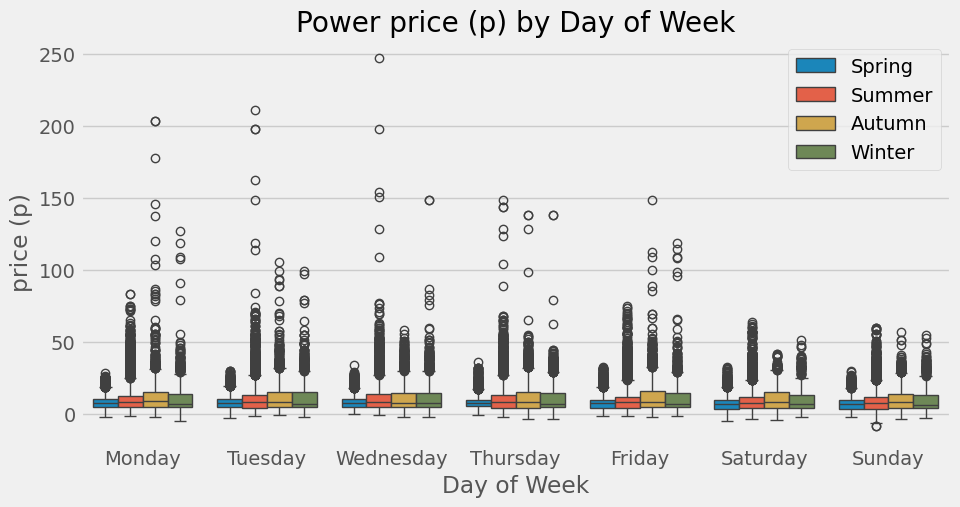

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='Indicative Wholesale Unit Price (p)',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power price (p) by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('price (p)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [66]:
split_date = '1-Jan-2024'
df_train = features_and_target.loc[df.Time <= split_date].copy()
df_test = features_and_target.loc[df.Time > split_date].copy()

In [72]:
df_train = df_train.rename(columns={'Time':'ds', 'Indicative Wholesale Unit Price (p)': 'y'})
df_test = df_test.rename(columns={'Time':'ds', 'Indicative Wholesale Unit Price (p)': 'y'})

In [73]:
df_train.head()

,ds,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekday,season,y
0,2019-07-22 18:30:00,18,0,3,7,2019,203,22,Monday,Summer,4.8
1,2019-07-22 19:00:00,19,0,3,7,2019,203,22,Monday,Summer,4.8
2,2019-07-22 19:30:00,19,0,3,7,2019,203,22,Monday,Summer,5.1
3,2019-07-22 20:00:00,20,0,3,7,2019,203,22,Monday,Summer,4.7
4,2019-07-22 20:30:00,20,0,3,7,2019,203,22,Monday,Summer,4.6


In [74]:
df_train_prophet = df_train[['ds', 'y']]
df_test_prophet = df_test[['ds', 'y']]

model = Prophet()
model.fit(df_train)

17:22:27 - cmdstanpy - INFO - Chain [1] start processing
17:24:18 - cmdstanpy - INFO - Chain [1] done processing


In [75]:
test_fcst = model.predict(df_test_prophet)

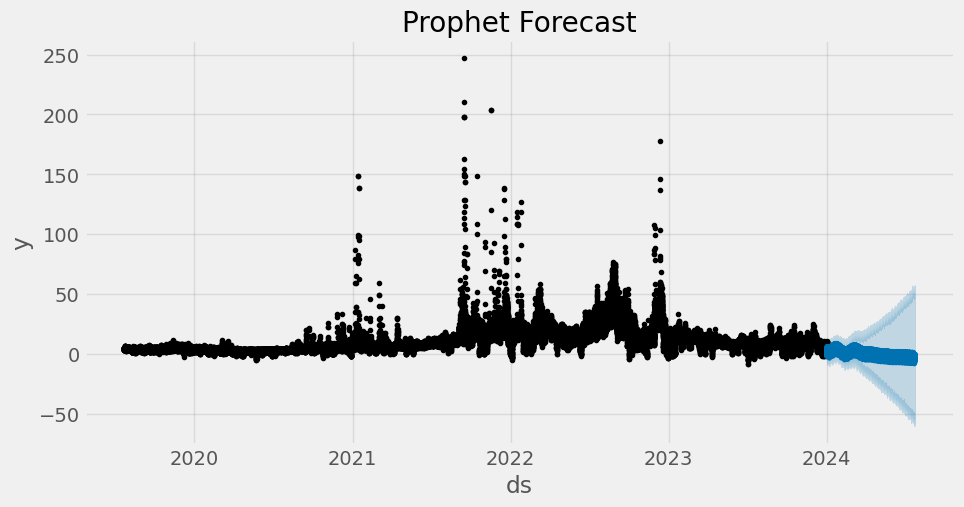

In [77]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

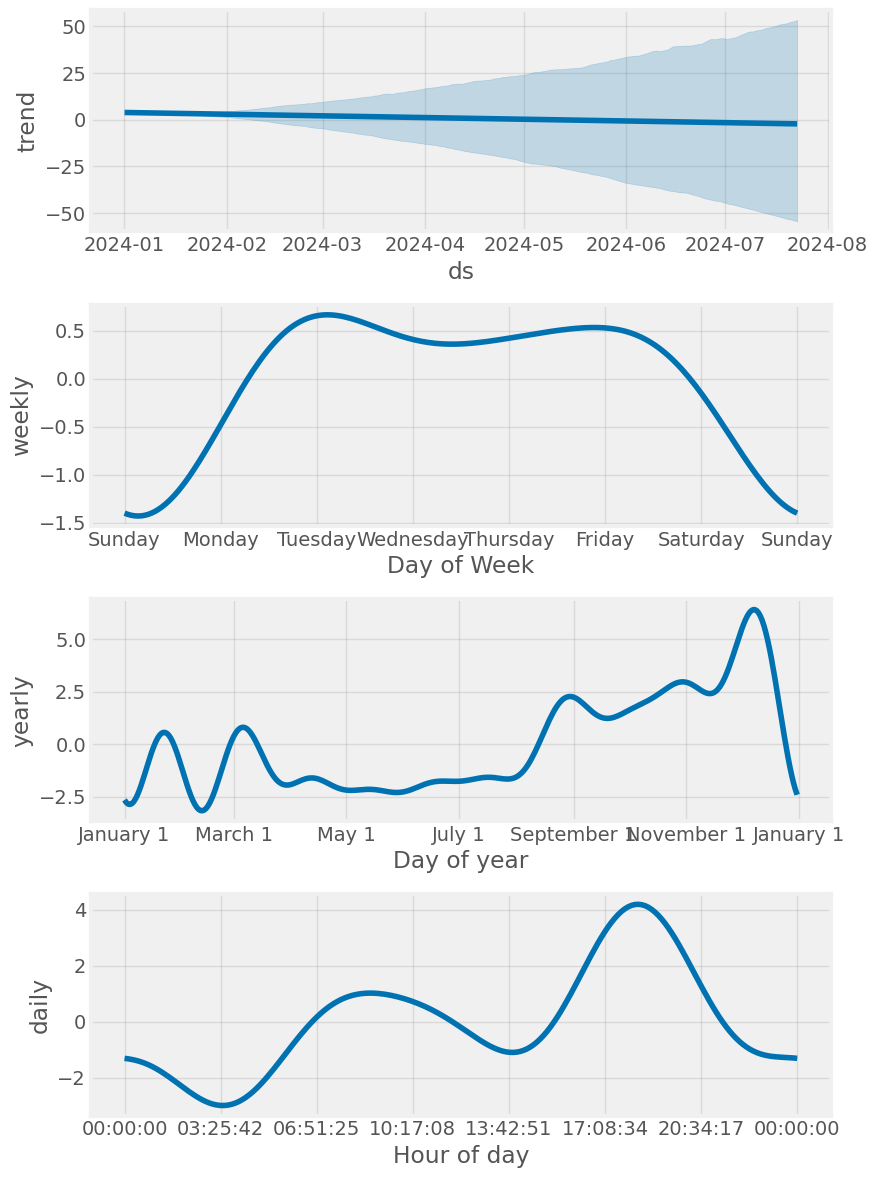

In [78]:
fig = model.plot_components(test_fcst)
plt.show()

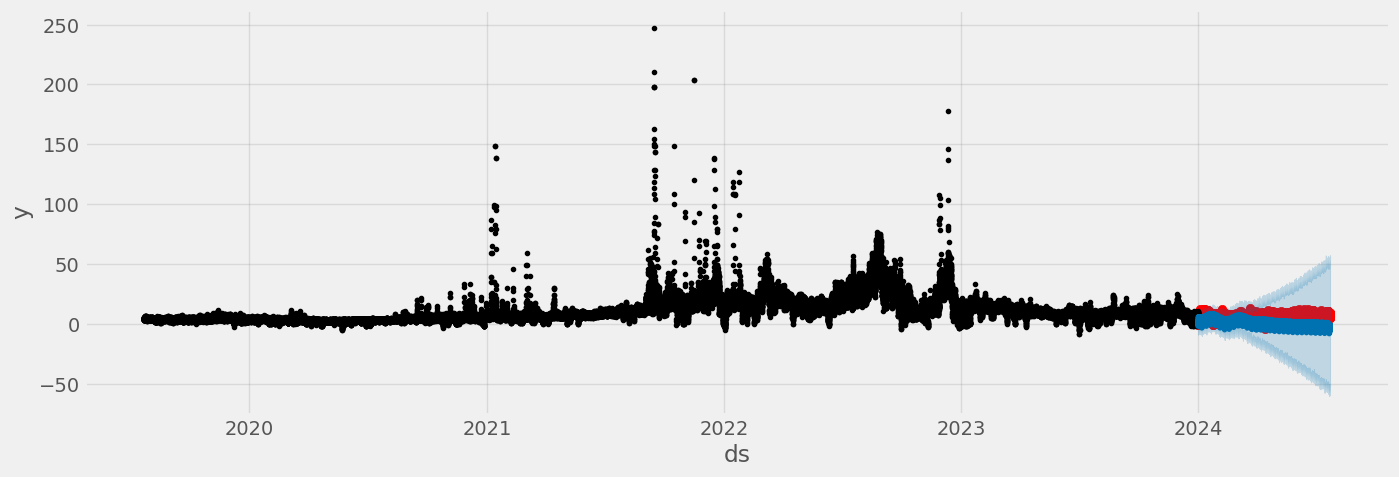

In [81]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test.ds, df_test['y'], color='r')
f = model.plot(test_fcst, ax=ax)

ConversionError: Failed to convert value(s) to axis units: '01-01-2024'

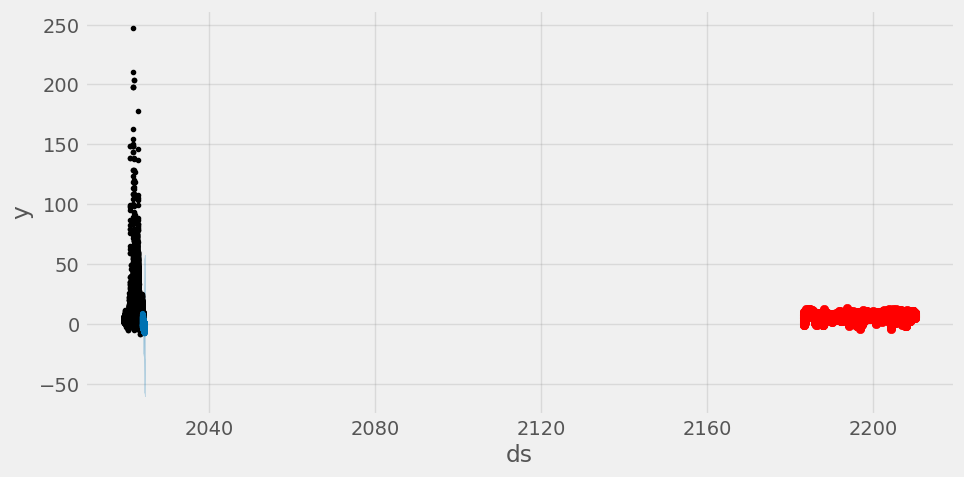

In [82]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_test.index, df_test['y'], color='r')
fig = model.plot(test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2024',
              upper='02-01-2024')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2024 Forecast vs Actuals')